In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
from zipfile import ZipFile
import seaborn as sns

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# TensorFlow ≥2.0-preview is required
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


**Cross-validation**

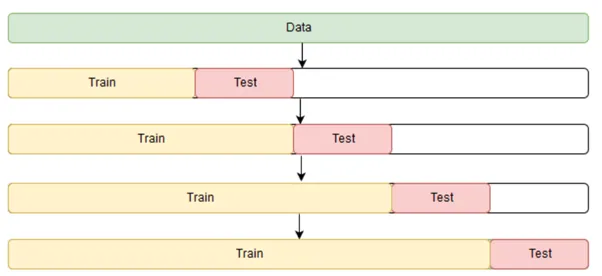

In [3]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)  # Ajuste para salida de una sola dimensión
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}")

In [4]:
def time_series_cv(X, y, model, n_splits, epochs=10, batch_size=512, input_size=1, hidden_size=64, output_size=1, device='cuda'):
    test_scores = np.zeros((n_splits, 5))
    tscv = TimeSeriesSplit(n_splits=n_splits)

    count = 0
    for train_idx, test_idx in tscv.split(X):
        print(f"Fold {count+1}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Añadir la dimensión de características (input_size=1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Create DataLoader for batching
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Build model if not passed (i.e., a fresh model for each fold)
        model.to(device)  # Use GPU if available
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Entrenar el modelo
        train_model(model, train_loader, criterion, optimizer, device, epochs)

        # Predicciones
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor.to(device))

        # Results
        y_pred = y_pred.cpu().numpy()  # Mover las predicciones a CPU y convertir a numpy array
        test_scores[count, 0] = round(mean_squared_error(y_test, y_pred), 3)
        test_scores[count, 1] = round(mean_squared_error(y_test, y_pred, squared=True), 3)
        test_scores[count, 2] = round(mean_absolute_error(y_test, y_pred), 3)
        test_scores[count, 3] = round(np.mean(np.abs(y_test - y_pred)) * 100)
        test_scores[count, 4] = round(r2_score(y_test, y_pred), 3)

        count += 1

    return test_scores

#**Load data**

In [5]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [6]:
# Import data
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [8]:
data = df['max. wv (m/s)']                       # Conjunto de datos a modelar
data = data.fillna(df['max. wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['max. wv (m/s)']
data.head()

,max. wv (m/s)
max. wv (m/s),
1.75,1.75
1.50,1.50
0.63,0.63
0.50,0.50
0.63,0.63


In [9]:
# Normalización de los datos
timeSerie = data.values[0:300000]
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))

window = 50 # Size of array

X = np.zeros([len(timeSerie)-window, window])
for i in range(len(timeSerie)-window):
  X[i,:] = timeSerie[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeSerie[window:]

X.shape, y.shape


((299950, 50), (299950,))

#**Vaninsh gradients rith RNNs**

Es un tipo de dificultad que se presenta en las redes neuronales recurrentes simples, donde los pesos de la red se van desvaneciendo a valores pequeños en la medida que se actualizan sus pesos por los algoritmos de gradiente descendente y *Backpropagation*

#**Gated Recurrent Unit (GRU)**

Este tipo de Red recurrente tiene como objetivo resolver el problema de *Vanish gradient* asociado con una red recurrente simple

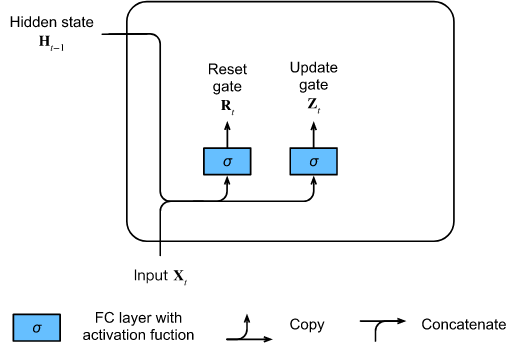

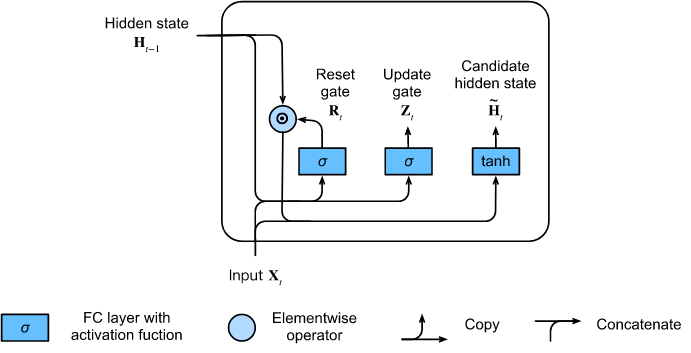

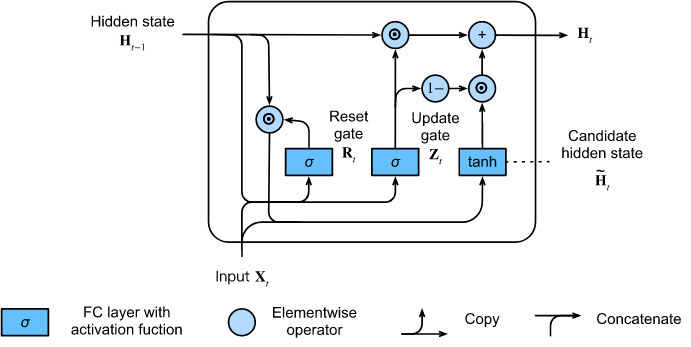

In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Tomar solo la salida del último paso
        return out

In [11]:
model = GRUNet(input_size=1, hidden_size=64, output_size=1)

In [12]:
test_scores = time_series_cv(X, y, model, n_splits=10, epochs=30, batch_size=1024)


Fold 1
Epoch [1/30], Loss: 0.0064
Epoch [2/30], Loss: 0.0022
Epoch [3/30], Loss: 0.0017
Epoch [4/30], Loss: 0.0016
Epoch [5/30], Loss: 0.0015
Epoch [6/30], Loss: 0.0015
Epoch [7/30], Loss: 0.0014
Epoch [8/30], Loss: 0.0014
Epoch [9/30], Loss: 0.0014
Epoch [10/30], Loss: 0.0014
Epoch [11/30], Loss: 0.0014
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0014
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2
Epoch [1/30], Loss: 0.0014
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0013
Epoch [6/30], Loss: 0.0013
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0013
Epoch [10/30], Loss: 0.0013
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3
Epoch [1/30], Loss: 0.0013
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0013
Epoch [6/30], Loss: 0.0013
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0013
Epoch [10/30], Loss: 0.0013
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4
Epoch [1/30], Loss: 0.0012
Epoch [2/30], Loss: 0.0012
Epoch [3/30], Loss: 0.0012
Epoch [4/30], Loss: 0.0012
Epoch [5/30], Loss: 0.0012
Epoch [6/30], Loss: 0.0012
Epoch [7/30], Loss: 0.0012
Epoch [8/30], Loss: 0.0012
Epoch [9/30], Loss: 0.0012
Epoch [10/30], Loss: 0.0012
Epoch [11/30], Loss: 0.0012
Epoch [12/30], Loss: 0.0012
Epoch [13/30], Loss: 0.0012
Epoch [14/30], Loss: 0.0012
Epoch [15/30], Loss: 0.0012
Epoch [16/30], Loss: 0.0012
Epoch [17/30], Loss: 0.0012
Epoch [18/30], Loss: 0.0012
Epoch [19/30], Loss: 0.0012
Epoch [20/30], Loss: 0.0012
Epoch [21/30], Loss: 0.0012
Epoch [22/30], Loss: 0.0012
Epoch [23/30], Loss: 0.0012
Epoch [24/30], Loss: 0.0012
Epoch [25/30], Loss: 0.0012
Epoch [26/30], Loss: 0.0012
Epoch [27/30], Loss: 0.0012
Epoch [28/30], Loss: 0.0012
Epoch [29/30], Loss: 0.0012
Epoch [30/30], Loss: 0.0012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5
Epoch [1/30], Loss: 0.0013
Epoch [2/30], Loss: 0.0012
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0012
Epoch [6/30], Loss: 0.0012
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0012
Epoch [9/30], Loss: 0.0012
Epoch [10/30], Loss: 0.0012
Epoch [11/30], Loss: 0.0012
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0012
Epoch [14/30], Loss: 0.0012
Epoch [15/30], Loss: 0.0012
Epoch [16/30], Loss: 0.0012
Epoch [17/30], Loss: 0.0012
Epoch [18/30], Loss: 0.0012
Epoch [19/30], Loss: 0.0012
Epoch [20/30], Loss: 0.0012
Epoch [21/30], Loss: 0.0012
Epoch [22/30], Loss: 0.0012
Epoch [23/30], Loss: 0.0012
Epoch [24/30], Loss: 0.0012
Epoch [25/30], Loss: 0.0012
Epoch [26/30], Loss: 0.0012
Epoch [27/30], Loss: 0.0012
Epoch [28/30], Loss: 0.0012
Epoch [29/30], Loss: 0.0012
Epoch [30/30], Loss: 0.0012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 6
Epoch [1/30], Loss: 0.0013
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0013
Epoch [6/30], Loss: 0.0013
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0013
Epoch [10/30], Loss: 0.0013
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 7
Epoch [1/30], Loss: 0.0013
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0013
Epoch [6/30], Loss: 0.0013
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0013
Epoch [10/30], Loss: 0.0013
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 8
Epoch [1/30], Loss: 0.0013
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Loss: 0.0013
Epoch [4/30], Loss: 0.0013
Epoch [5/30], Loss: 0.0013
Epoch [6/30], Loss: 0.0013
Epoch [7/30], Loss: 0.0013
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0013
Epoch [10/30], Loss: 0.0013
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0013
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0013
Epoch [18/30], Loss: 0.0013
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0013
Epoch [22/30], Loss: 0.0013
Epoch [23/30], Loss: 0.0013
Epoch [24/30], Loss: 0.0013
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0013
Epoch [27/30], Loss: 0.0013
Epoch [28/30], Loss: 0.0013
Epoch [29/30], Loss: 0.0013
Epoch [30/30], Loss: 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 9
Epoch [1/30], Loss: 0.0012
Epoch [2/30], Loss: 0.0012
Epoch [3/30], Loss: 0.0012
Epoch [4/30], Loss: 0.0012
Epoch [5/30], Loss: 0.0012
Epoch [6/30], Loss: 0.0012
Epoch [7/30], Loss: 0.0012
Epoch [8/30], Loss: 0.0012
Epoch [9/30], Loss: 0.0012
Epoch [10/30], Loss: 0.0012
Epoch [11/30], Loss: 0.0012
Epoch [12/30], Loss: 0.0012
Epoch [13/30], Loss: 0.0012
Epoch [14/30], Loss: 0.0012
Epoch [15/30], Loss: 0.0012
Epoch [16/30], Loss: 0.0012
Epoch [17/30], Loss: 0.0012
Epoch [18/30], Loss: 0.0012
Epoch [19/30], Loss: 0.0012
Epoch [20/30], Loss: 0.0012
Epoch [21/30], Loss: 0.0012
Epoch [22/30], Loss: 0.0012
Epoch [23/30], Loss: 0.0012
Epoch [24/30], Loss: 0.0012
Epoch [25/30], Loss: 0.0012
Epoch [26/30], Loss: 0.0012
Epoch [27/30], Loss: 0.0012
Epoch [28/30], Loss: 0.0012
Epoch [29/30], Loss: 0.0012
Epoch [30/30], Loss: 0.0012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 10
Epoch [1/30], Loss: 0.0012
Epoch [2/30], Loss: 0.0012
Epoch [3/30], Loss: 0.0012
Epoch [4/30], Loss: 0.0012
Epoch [5/30], Loss: 0.0012
Epoch [6/30], Loss: 0.0012
Epoch [7/30], Loss: 0.0012
Epoch [8/30], Loss: 0.0012
Epoch [9/30], Loss: 0.0012
Epoch [10/30], Loss: 0.0012
Epoch [11/30], Loss: 0.0012
Epoch [12/30], Loss: 0.0012
Epoch [13/30], Loss: 0.0012
Epoch [14/30], Loss: 0.0012
Epoch [15/30], Loss: 0.0012
Epoch [16/30], Loss: 0.0012
Epoch [17/30], Loss: 0.0012
Epoch [18/30], Loss: 0.0012
Epoch [19/30], Loss: 0.0012
Epoch [20/30], Loss: 0.0012
Epoch [21/30], Loss: 0.0012
Epoch [22/30], Loss: 0.0012
Epoch [23/30], Loss: 0.0012
Epoch [24/30], Loss: 0.0012
Epoch [25/30], Loss: 0.0012
Epoch [26/30], Loss: 0.0012
Epoch [27/30], Loss: 0.0012
Epoch [28/30], Loss: 0.0012
Epoch [29/30], Loss: 0.0012
Epoch [30/30], Loss: 0.0012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


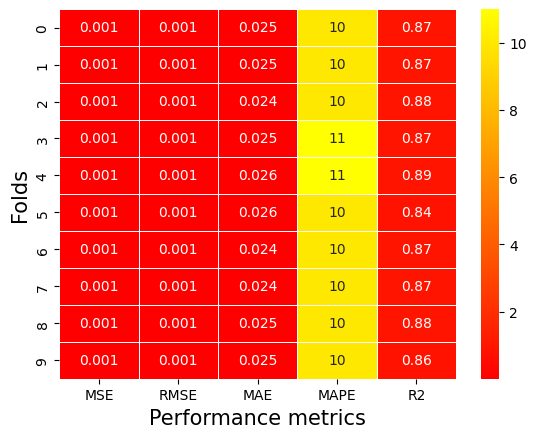

In [15]:
n_splits = 15
ax = sns.heatmap(test_scores, linewidth=0.5, cmap='autumn', annot=True)
plt.xlabel('Performance metrics', fontsize = 15)
plt.ylabel('Folds', fontsize = 15)
plt.xticks(np.arange(0,5)+0.5, ['MSE','RMSE','MAE','MAPE','R2'])
#plt.yticks(np.arange(0,n_splits)+0.5, np.arange(1,n_splits+1))
plt.show()